In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import random
from tqdm import tqdm
import cv2

characters = np.load('character_font.npz')['images']

In [2]:
class Encoder(nn.Module):

  def __init__(self, seed_size, img_channel):

    super(Encoder, self).__init__()
    self.encoder = nn.Sequential(

        nn.Conv2d(img_channel, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
    )
    self.mu_fc = nn.Conv2d(512, seed_size, 2, 1, 0, bias=False)
    self.sigma_fc = nn.Conv2d(512, seed_size, 2, 1, 0, bias=False)
    self.kl = 0

  def forward(self,input,N):
    encoded = self.encoder(input)
    mu = self.mu_fc(encoded).mean([-2,-1])
    sigma = torch.exp(self.sigma_fc(encoded).mean([-2,-1]))
    z = mu + sigma*N.sample(mu.shape)
    self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
    return z

class Decoder(nn.Module):

  def __init__(self, seed_size, img_channel):

    super(Decoder, self).__init__()

    self.conv_transpose_block_1 = nn.Sequential(
        nn.ConvTranspose2d(seed_size, 512, 4, 1, 0, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True)) 
    
    self.conv_transpose_block_2 = nn.Sequential(
        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True)) 

    self.conv_transpose_block_3 = nn.Sequential(
        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True)) 

    self.conv_transpose_block_4 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True)) 

    self.conv_transpose_block_5 = nn.Sequential(
        nn.ConvTranspose2d(64, img_channel, 1, 1, 0, bias=False),
        nn.Sigmoid())

  def forward(self, input):
    input = self.conv_transpose_block_1(input)
    input = self.conv_transpose_block_2(input)
    input = self.conv_transpose_block_3(input)
    input = self.conv_transpose_block_4(input)
    input = self.conv_transpose_block_5(input)
    return input

class Discriminator(nn.Module):

  def __init__(self, img_channel, num_classes):

    super(Discriminator, self).__init__()
    self.block = nn.Sequential(

        nn.Conv2d(img_channel, 32, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(32, 64, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
    )

    self.dis_out = nn.Conv2d(512, 1, 1, 1, 0, bias=False)
    self.pred = nn.Sequential(
        nn.Conv2d(512, num_classes, 1, 1, 0, bias=False),
        nn.Softmax(dim=1)
    )

  def forward(self,input):
    x = self.block(input)
    return self.dis_out(x), self.pred(x)

def plotter(images):
  f = -(-len(images)//3)
  fig,ax = plt.subplots(3,f,figsize=(5*f, 15))
  for i in range(len(images)):
    ax[i%3,i//3].imshow(images[i,0])
  for aa in ax:
    for aaa in aa:
      aaa.axis("off")
  plt.show()

def get_one_hot(a, maximum=25):
  b = np.zeros((a.size, maximum + 1))
  b[np.arange(a.size), a] = 1
  return b

In [3]:
seed_size = 128
num_class = 26
img_ch = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

enc = Encoder(seed_size, img_ch).to(device)
gen = Decoder(seed_size+num_class, img_ch).to(device)
dis = Discriminator(img_ch, num_class).to(device)
gen.load_state_dict(torch.load('gen.pt',map_location=device))
dis.load_state_dict(torch.load('dis.pt',map_location=device))
enc.load_state_dict(torch.load('enc.pt',map_location=device))
N = torch.distributions.Normal(torch.tensor(0).float().to(device), torch.tensor(1).float().to(device))

@torch.no_grad()
def get_latent(img):
    if img is not None:
        enc.eval()
        latent = enc(torch.tensor(img).float().to(device), N)
        return latent[0].cpu().reshape(1,-1)
    else:
        return torch.randn(1, seed_size).to(device)

@torch.no_grad()
def get_demo(latent):
    gen.eval()
    visualize_noise = latent
    visualize_noise = torch.cat([visualize_noise for _ in range(num_class)], axis=0)
    onehot = torch.tensor(get_one_hot(np.arange(num_class)))
    visualize_noise = torch.cat([visualize_noise,onehot],axis=1).reshape(num_class,-1,1,1)
    pred = gen(visualize_noise.float())
    return pred
    
@torch.no_grad()
def get_predictions(text, latent):
    gen.eval()
    order = []
    for i in text.upper():
        o = ord(i)-65 
        if o < 0 or 0 > 25:
            order.append(26)
        else:
            order.append(o)
    onehot = torch.tensor(get_one_hot(np.array(order), 26)[:,:26])
    visualize_noise = torch.cat([latent for _ in range(len(onehot))],axis=0)
    visualize_noise = torch.cat([visualize_noise,onehot],axis=1).reshape(len(onehot),-1,1,1)
    pred = gen(visualize_noise.float())
    for i, num in enumerate(order):
        if num == 26:
            pred[i] = 0*pred[i]
    return pred

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
import torchvision
from scipy.linalg import sqrtm

# Define your Encoder, Decoder, Discriminator, plotter, get_one_hot, and other functions here
def calculate_inception_score_and_fid(generated_images, real_images):
    inception_model = torchvision.models.inception_v3(pretrained=True, transform_input=False, aux_logits=True)
    inception_model = inception_model.eval()

    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((299, 299)),
        transforms.Grayscale(num_output_channels=3),  # Convert to RGB
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    ])

    # Process generated images
    generated_images = torch.stack([preprocess(image.squeeze()) for image in generated_images])
    predictions = inception_model(generated_images)

    probabilities = torch.nn.functional.softmax(predictions, dim=1)
    entropy = torch.sum(probabilities * torch.log(probabilities), dim=1)
    inception_score = torch.exp(torch.mean(entropy))

    # Process real images
    real_images = torch.stack([preprocess(image.squeeze()) for image in real_images])
    features_real = inception_model(real_images).detach().numpy()
    features_generated = predictions.detach().numpy()

    mean_real = np.mean(features_real, axis=0)
    mean_generated = np.mean(features_generated, axis=0)
    cov_real = np.cov(features_real, rowvar=False)
    cov_generated = np.cov(features_generated, rowvar=False)

    diff = mean_real - mean_generated
    sqrt_cov_product = sqrtm(cov_real.dot(cov_generated))
    fid = np.real(diff.dot(diff) + np.trace(cov_real + cov_generated - 2 * sqrt_cov_product))

    return inception_score.item(), fid.item()

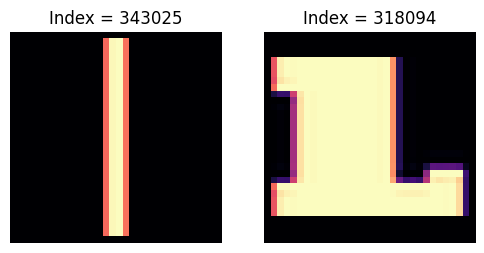

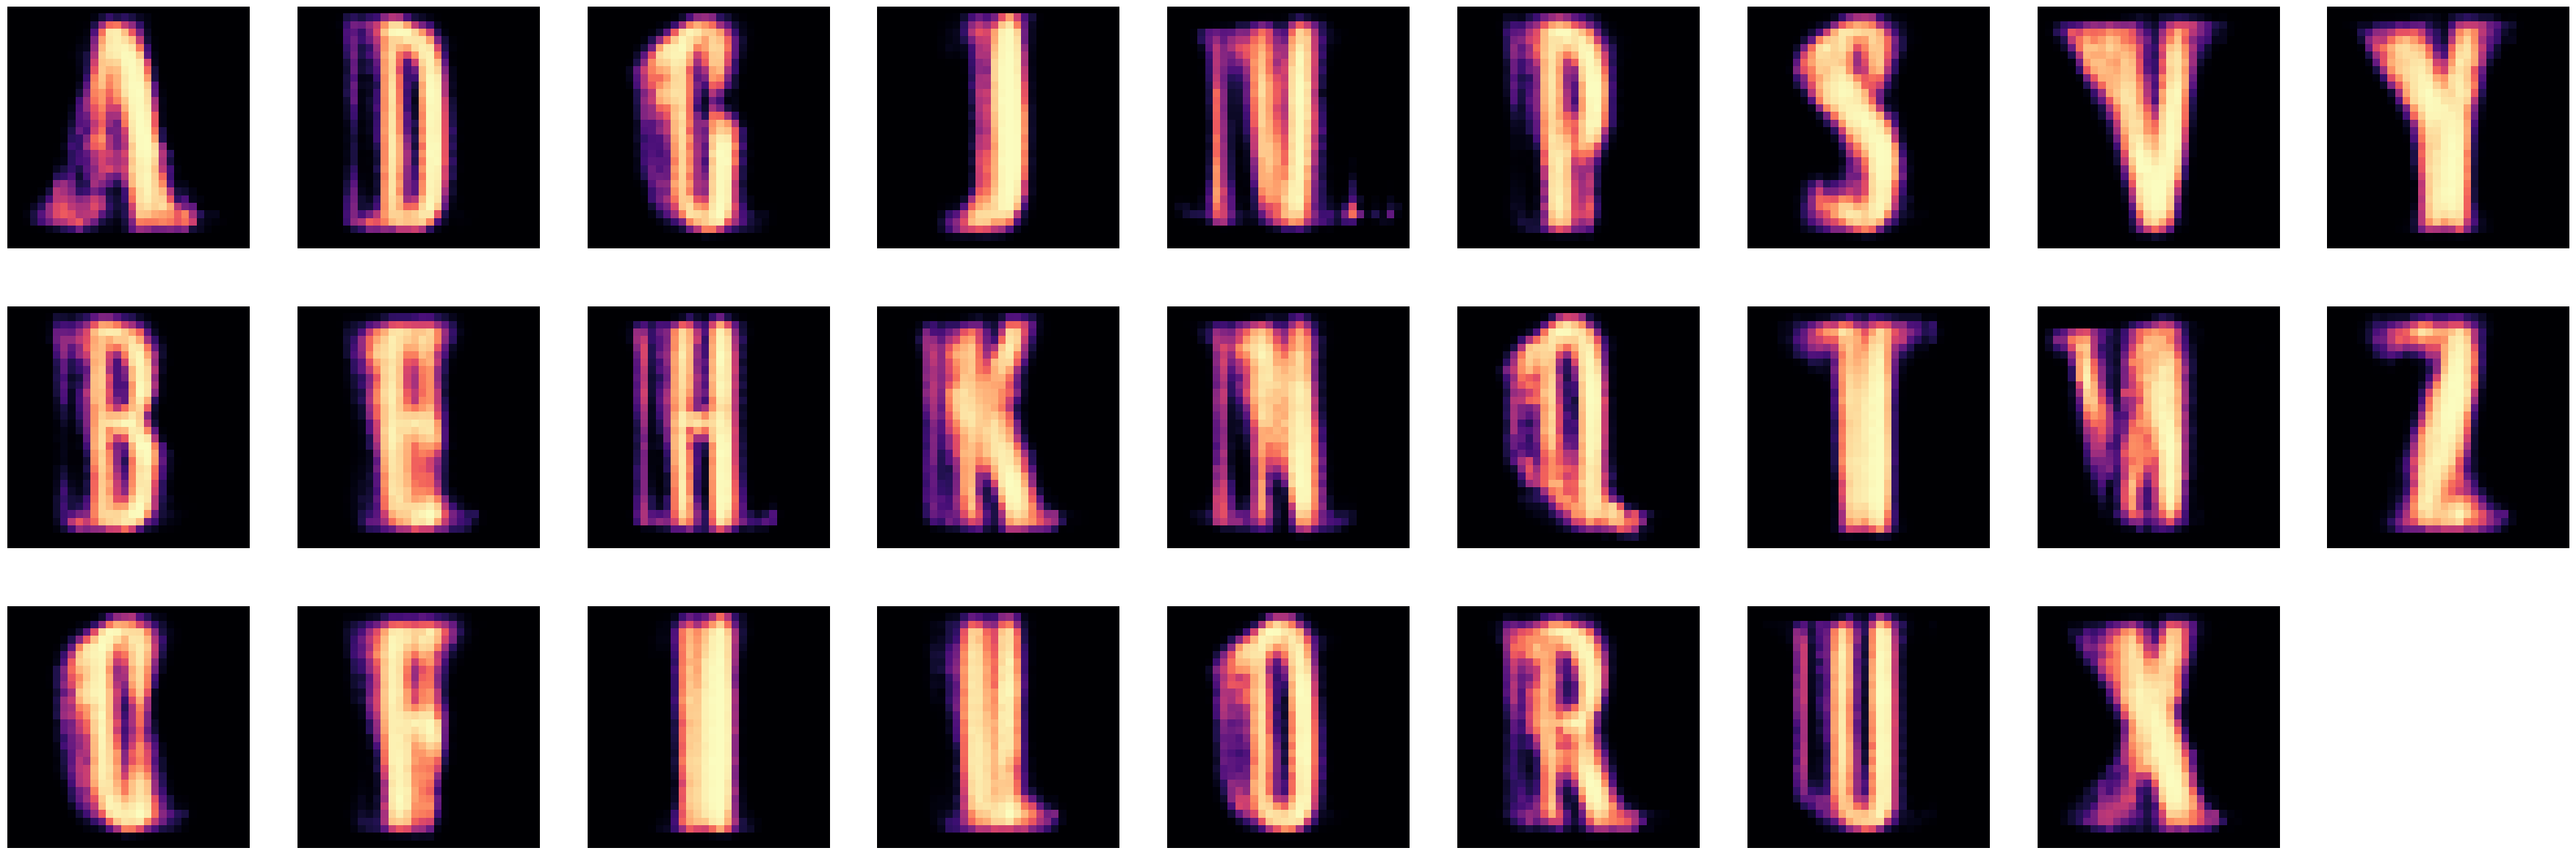

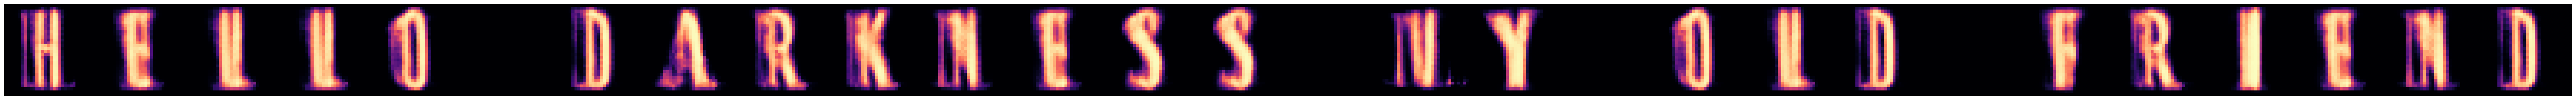

C:\Users\Dinesh Madhav\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Dinesh Madhav\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception Score: 0.01677566021680832
FID: 1.4965776766268446e+51


In [5]:
import matplotlib as mpl
mpl.rc('image', cmap='magma')

n = 2
idx = np.random.choice(np.arange(characters.shape[0]), n, replace=False)
fig, ax = plt.subplots(1, n, figsize=(n*3, 3))
images = []
for i, j in enumerate(idx):
    ax[i].set_title(f"Index = {j}")
    img = characters[j].reshape(1, 1, 32, 32) / 255
    images.append(img)
    ax[i].imshow(img[0, 0])
    ax[i].axis('off')

with torch.no_grad():
    latent = sum([get_latent(im) for im in images]) / n
    pred = get_demo(latent)
    plotter(pred.cpu())

    # Generate random noise and get predictions
    pred = get_predictions("Hello darkness my old friend", latent)
    plt.figure(figsize=(len(pred)*3, 3))
    plt.imshow(np.concatenate(list(pred.cpu().numpy()), axis=2)[0])
    plt.axis('off')
    plt.show()

    # Calculate Inception Score and FID
    inception_score, fid = calculate_inception_score_and_fid(pred.cpu().numpy(), images)
    print("Inception Score:", inception_score)
    print("FID:", fid)
